In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt,math
%matplotlib inline

In [ ]:
def f(x):
    return 4*x**2 + 5*x + 7

In [ ]:
f(3)

58

[<matplotlib.lines.Line2D>]

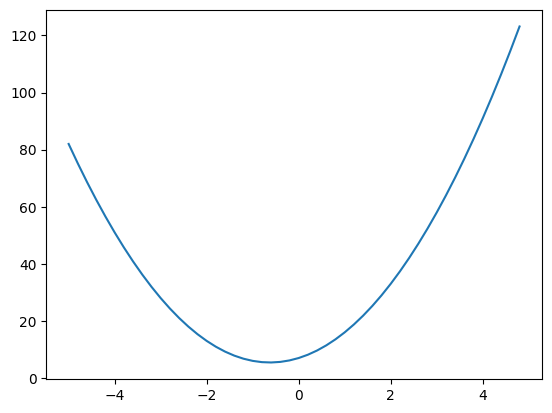

In [ ]:
xz  = np.arange(-5, 5, 0.20)
yz = f(xz)
plt.plot(xz,yz)

In [ ]:
h= 1e-4
x= 3.
(f(x + h) -f(x))/h

29.00040000007209

In [ ]:
a = 2.5
b = 3.5
c = 15
d = a*b+c
print(d)

23.75


In [ ]:
h = 0.00001

#inputs
a = 2.5
b = -3.5
c = 15

d1 = a*b+c
c += h
d2 = a*b+c
print('d1',d1)
print('d2',d2)
slope = (d2-d1)/h
print('slope', slope)

d1 6.25
d2 6.25001
slope 0.9999999999621422


In [ ]:
class value:
    def __init__(self,data,_children=(), _op = '', label =''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda:None
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self,other):
        other = other if isinstance(other, value) else value(other)# to wrap interger into value object to perform the operation(to allow a+1)
        out = value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 *out.grad
            other.grad += 1.0 *out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data *out.grad
            other.grad += self.data *out.grad
        out._backward = _backward
        return out
    
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other): # a fallback to check swap the order of operance to perform the task(operation)[ 2*a redirected to a*2]
        return self*other
    
    def exp(self):
        x = self.data
        out = value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data *out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers of now"
        out = value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other *(self.data **(other-1))) * out.grad
        out._backward = _backward
    
        return out
    
    def __truediv__(self,other): #self/other
        return self * other**-1
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad =1.0
        for node in reversed(topo):
            node._backward()
            

In [ ]:
a = value(2.0,label='a')
b = value(3.0, label='b')
a-b

Value(data=-1.0)

In [ ]:
a-b

Value(data=-1.0)

In [ ]:
from graphviz import Digraph


def trace(root):
    # builds all the set of all nodes and edges in a graph
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR - Left to Right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(name = uid, label = "{ %s|data %.4f| grad %.4f}" % (n.label,n.data,n.grad), shape = 'record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name= uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op,uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot    

#### Here we are going to calcualte gradients manually, with the derivative eq
L = d*f  
dL/dd -> f  

(f(x+h) - f(x))/h  

((d+h)*f - (d*f))/h  
(d*f+h*f - d*f)/h  
(h*f)/h  
f  

dd/dc = 1.   
dd/de = 1.    
d = c + e    

(f(x+h)-f(x))/h  
((c+h+e) - (c+e))/h  
(c+h+e-c-e)/h  
h/h  
1.0  

want:  
dL/dc = (dL/dd)*(dd/dc) # chain rule  
know:  
dL/dd  
dd/dc  

dL/de = 2.0  
de/da = b, de/db = >a # those are the local gradients  
dL/da = (dL/de)*(de/da)  


In [ ]:
#inputs
x1 = value(2.0, label = 'x1')
x2 = value(0.0, label = 'x2')
#weights
w1 = value(-3.0, label = 'w1')
w2 = value(1.0, label = 'w2')
#bias
b = value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

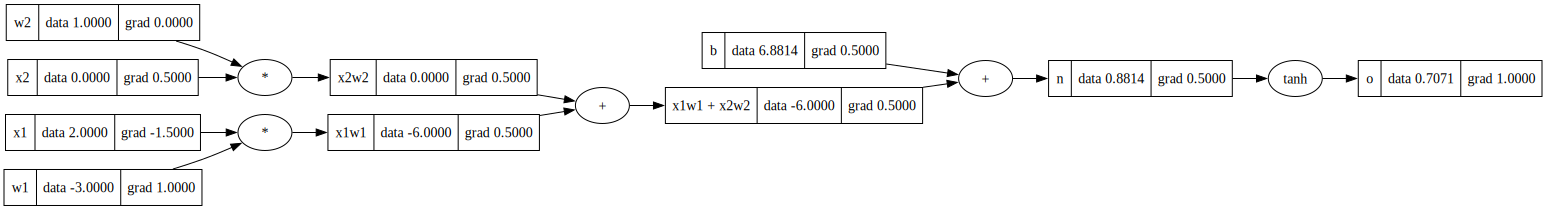

In [ ]:
draw_dot(o)

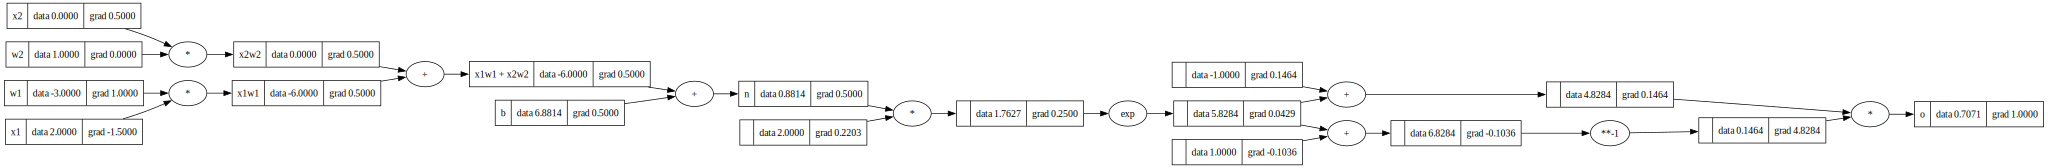

In [ ]:
#inputs
x1 = value(2.0, label = 'x1')
x2 = value(0.0, label = 'x2')
#weights
w1 = value(-3.0, label = 'w1')
w2 = value(1.0, label = 'w2')
#bias
b = value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o =  (e - 1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch
import random

In [ ]:
class Neuron:
    def __init__(self,ninp):
        self.w = [value(random.uniform(-1,1)) for _ in range(ninp)]
        self.b = value(random.uniform(-1,1))
        
    def __call__(self,x):
        # w*x +b
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
class Layer:
    def __init__(self,ninp,nout):
        self.nuerons = [Neuron(ninp) for n in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.nuerons]
        return outs[0]if len(outs)==1 else outs
        
class MLP:
    def __init__(self, ninp, nouts):
        sz = [ninp] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
        
x = [2.0,3.0,-1]
n= MLP(3,[4,4,1])
n(x)

Value(data=-0.9019690846525661)

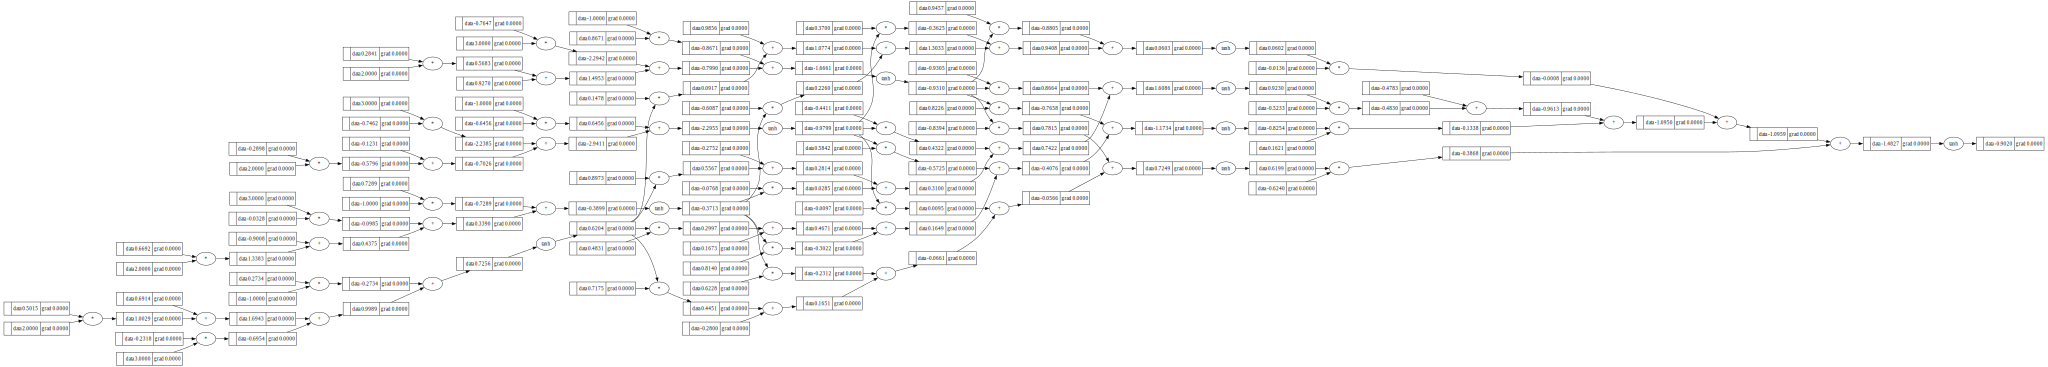

In [ ]:
draw_dot(n(x))